In [7]:
import pandas as pd

In [8]:
data = pd.read_csv("bank-additional-full.csv",sep = ";")

In [9]:
df = pd.DataFrame(data)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [10]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

The column duration was removed because it introduces data leakage.
Duration refers to the length of the last phone call, which is only known after contacting the customer.Our goal is to predict subscription before the call; therefore, this feature would not be available in real-world predictions and would lead to artificially inflated accuracy.

In [11]:
df = df.drop('duration', axis=1)

In this dataset, the value 999 in the pdays column means the client was never contacted before in a previous marketing campaign.
We convert this into a new binary feature:

1 : client was contacted before

0 : client was never contacted before

This makes the information easier for the model to understand and improves prediction quality.

In [12]:
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,was_contacted_before
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0


In [13]:
# Split Features and Target
X = df.drop('y', axis=1)
y = df['y'].map({'no':0, 'yes':1})

In [16]:
# Identify Categorical and Numerical Columns
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

cat_cols, num_cols

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'],
 ['age',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed',
  'was_contacted_before'])

Many columns in this dataset are categorical (e.g., job, education, marital).
Machine learning models cannot directly work with text values, so we convert these categorical features into numeric form using OneHotEncoder.

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

Plots a bar chart of the target variable, the x-axis shows the classes (yes and no), and the y-axis shows how many samples belong to each class.This helps visualize class imbalance in the dataset.

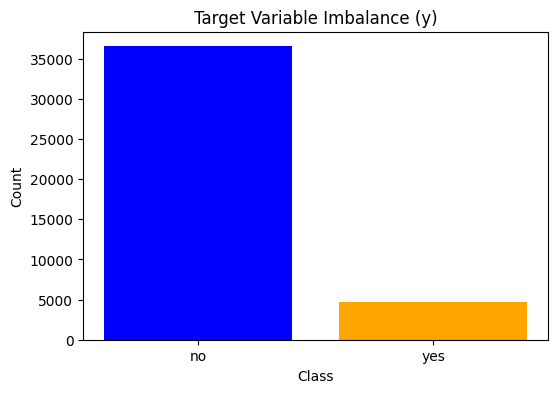

In [25]:
import matplotlib.pyplot as plt

counts = df['y'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values,color=['blue', 'orange'])
plt.title("Target Variable Imbalance (y)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

SMOTE for Imbalance Handling

The dataset is highly imbalanced, with far more “no” samples than “yes”.
To avoid the model becoming biased toward the majority class, we use SMOTE (Synthetic Minority Oversampling Technique).

SMOTE creates new synthetic examples for the minority class by interpolating between existing minority samples.This helps the model learn patterns from both classes more effectively and improves overall prediction performance.

In [26]:
from imblearn.over_sampling import SMOTE

X_pre = preprocessor.fit_transform(X)
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_pre, y)

After applying SMOTE, the minority class (yes) is oversampled to match the majority class (no), resulting in a balanced dataset.This balanced distribution helps the model learn equally from both classes.

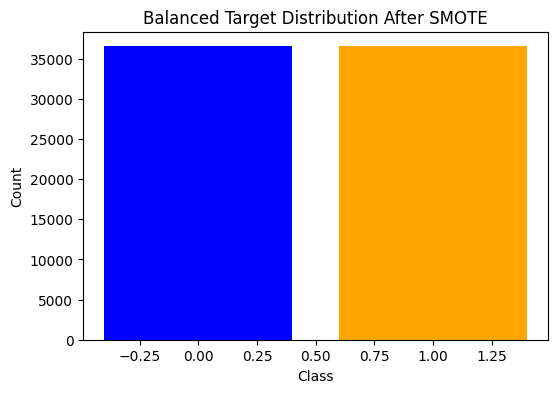

In [30]:
counts = y_res.value_counts()

plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values,color=['blue', 'orange'])
plt.title("Balanced Target Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
# Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Train Random Forest Model

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200)

We use predict_proba(X_test)[:, 1] to extract the probability of the positive class (class 1 = yes).
Most evaluation metrics such as AUC and ROC require the positive-class probability.
Since our goal is to predict which customers are likely to subscribe, we focus on the probability of class 1.

In [ ]:
# Predictions and Evaluation

from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7332
           1       0.96      0.92      0.94      7288

    accuracy                           0.94     14620
   macro avg       0.94      0.94      0.94     14620
weighted avg       0.94      0.94      0.94     14620

AUC: 0.9775327096444439

Confusion Matrix
 [[7019  313]
 [ 583 6705]]


In [34]:
import joblib

# Save preprocessor and model
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(model, "model.pkl")

print("Saved preprocessor.pkl and model.pkl")

Saved preprocessor.pkl and model.pkl
